In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
reconstructed_model = keras.models.load_model("asl_model")

In [3]:
cv2_image = cv2.imread("american_sign_language/b/b_1_rotate_1.jpeg")
cv2_image = cv2.resize(cv2_image, (150, 150))
cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)

In [4]:
dataset = os.listdir("american_sign_language")
labels = next(os.walk("american_sign_language"))[1]
print(labels)

['a', 'b', 'c', 'close', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'open', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [5]:
prediction = reconstructed_model.predict(np.array([cv2_image]))
print(prediction)

1/1 [==============================] - 8s 8s/step
[[3.8563795e-02 1.0000000e+00 3.4156059e-05 1.4351907e-01 6.5141713e-14
  5.6116804e-03 1.0000000e+00 1.6873485e-09 9.9993563e-01 6.4456426e-13
  2.0868440e-15 7.4749577e-01 6.5846188e-20 3.6273718e-02 2.0630254e-01
  9.9996924e-01 5.5089769e-15 1.4713283e-15 5.0496779e-02 1.5433689e-11
  2.1588913e-10 3.0177425e-08 1.0000000e+00 3.1979228e-09 9.2068422e-01
  1.2445845e-11 1.5980165e-08 1.1031296e-13]]


In [6]:
letter = labels[np.argmax(prediction)]
confidence = np.max(prediction)
txt = f"PRED: {letter}\nCONF: {confidence * 100:.2f}%"
print(txt)

PRED: b
CONF: 100.00%


In [7]:
def add_text_to_image(
        image_rgb: np.ndarray,
        label: str,
        top_left_xy: tuple = (0, 0),
        font_scale: float = 1,
        font_thickness: float = 1,
        font_face=cv2.FONT_HERSHEY_SIMPLEX,
        font_color_rgb: tuple = (0, 0, 255),
        bg_color_rgb: [tuple] = None,
        outline_color_rgb: [tuple] = None,
        line_spacing: float = 1,
):
    """
    Adds text (including multi line text) to images.
    You can also control background color, outline color, and line spacing.

    outline color and line spacing adopted from: https://gist.github.com/EricCousineau-TRI/596f04c83da9b82d0389d3ea1d782592
    """
    OUTLINE_FONT_THICKNESS = 3 * font_thickness

    im_h, im_w = image_rgb.shape[:2]

    for line in label.splitlines():
        x, y = top_left_xy

        # ====== get text size
        if outline_color_rgb is None:
            get_text_size_font_thickness = font_thickness
        else:
            get_text_size_font_thickness = OUTLINE_FONT_THICKNESS

        (line_width, line_height_no_baseline), baseline = cv2.getTextSize(
            line,
            font_face,
            font_scale,
            get_text_size_font_thickness,
        )
        line_height = line_height_no_baseline + baseline

        if bg_color_rgb is not None and line:
            # === get actual mask sizes with regard to image crop
            if im_h - (y + line_height) <= 0:
                sz_h = max(im_h - y, 0)
            else:
                sz_h = line_height

            if im_w - (x + line_width) <= 0:
                sz_w = max(im_w - x, 0)
            else:
                sz_w = line_width

            # ==== add mask to image
            if sz_h > 0 and sz_w > 0:
                bg_mask = np.zeros((sz_h, sz_w, 3), np.uint8)
                bg_mask[:, :] = np.array(bg_color_rgb)
                image_rgb[
                y: y + sz_h,
                x: x + sz_w,
                ] = bg_mask

        # === add outline text to image
        if outline_color_rgb is not None:
            image_rgb = cv2.putText(
                image_rgb,
                line,
                (x, y + line_height_no_baseline),  # putText start bottom-left
                font_face,
                font_scale,
                outline_color_rgb,
                OUTLINE_FONT_THICKNESS,
                cv2.LINE_AA,
            )
        # === add text to image
        image_rgb = cv2.putText(
            image_rgb,
            line,
            (x, y + line_height_no_baseline),  # putText start bottom-left
            font_face,
            font_scale,
            font_color_rgb,
            font_thickness,
            cv2.LINE_AA,
        )
        top_left_xy = (x, y + int(line_height * line_spacing))
    return image_rgb

In [8]:
#Resize the image back to the original size
cv2_image = cv2.resize(cv2_image, (400, 400))
# Add the text to the image
cv2_image = add_text_to_image(cv2_image, txt, (0, 0), 0.8, 1, cv2.FONT_HERSHEY_SIMPLEX, (0, 0, 255), (255, 255, 255),
                              (0, 0, 0), 1)

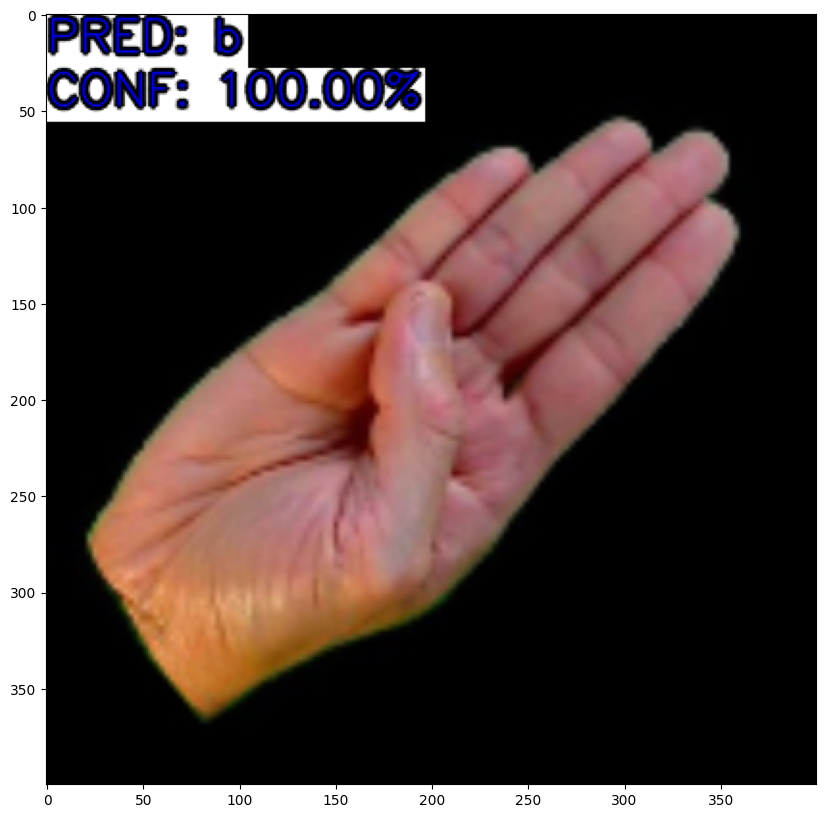

In [9]:
# Display the image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cv2_image)
plt.show()